In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/FakeLense/

/content/drive/MyDrive/FakeNews


# FakeLenseV2 : Fake News Detection Model Integrating LLMs and Reinforcement Learning 

Episode 1 - Total Reward: -55 (-24.44/100)
Episode 2 - Total Reward: 119 (52.89/100)
Episode 3 - Total Reward: 191 (84.89/100)
Episode 4 - Total Reward: 191 (84.89/100)
Episode 5 - Total Reward: 199 (88.44/100)
Episode 6 - Total Reward: 203 (90.22/100)
Episode 7 - Total Reward: 201 (89.33/100)
Episode 8 - Total Reward: 205 (91.11/100)
Episode 9 - Total Reward: 205 (91.11/100)
Episode 10 - Total Reward: 207 (92.00/100)
Episode 11 - Total Reward: 203 (90.22/100)
Episode 12 - Total Reward: 201 (89.33/100)
Episode 13 - Total Reward: 207 (92.00/100)
Episode 14 - Total Reward: 207 (92.00/100)
Episode 15 - Total Reward: 219 (97.33/100)
Episode 16 - Total Reward: 221 (98.22/100)
Episode 17 - Total Reward: 221 (98.22/100)
Episode 18 - Total Reward: 225 (100.00/100)
Episode 19 - Total Reward: 221 (98.22/100)
Episode 20 - Total Reward: 221 (98.22/100)
Episode 21 - Total Reward: 219 (97.33/100)
Episode 22 - Total Reward: 221 (98.22/100)
Episode 23 - Total Reward: 225 (100.00/100)
Episode 24 - Tota

<ipython-input-7-6d6dc03cd26e>:234: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.model.load_state_dict(torch.load('./models/best_model_v2.pth', map_location=agent.dev

Article: NASA launches new satellite to monitor climate change.
Prediction: Real News

Article: Global health experts discuss strategies to combat antibiotic resistance.
Prediction: Real News

Article: U.S. government announces new initiatives to combat cybersecurity threats.
Prediction: Real News

Article: G7 leaders commit to reducing carbon emissions by 50% by 2030.
Prediction: Real News

Article: European Union agrees on stricter privacy regulations for tech companies.
Prediction: Real News

Article: The United Nations sets new targets for global poverty reduction.
Prediction: Real News

Article: WHO announces new campaign to eliminate polio in Africa by 2025.
Prediction: Real News

Article: Pentagon unveils new artificial intelligence-driven defense systems.
Prediction: Real News

Article: Global leaders pledge to accelerate renewable energy adoption by 2035.
Prediction: Real News

Article: CDC releases new study on mental health impacts of the pandemic.
Prediction: Real News

Art

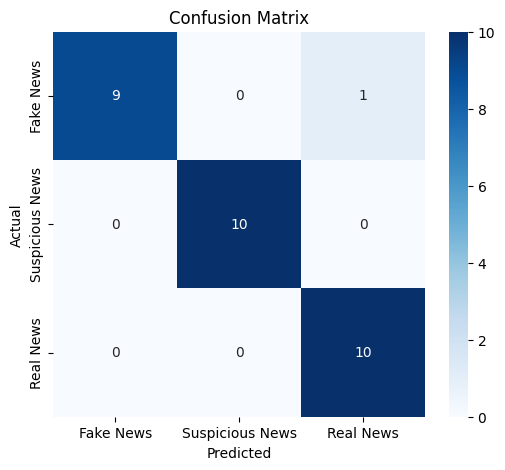

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import random
import os
import json

# STEP 0: BERT-based or RoBERTa-based Vectorizer
class BERTVectorizer:
    def __init__(self):
        llm_name = "bert-base-uncased"
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = BertTokenizer.from_pretrained(llm_name)
        self.model = BertModel.from_pretrained(llm_name).to(self.device)

    def vectorize(self, text, pooling=False):
        inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(self.device)
        with torch.no_grad():
            outputs = self.model(**inputs)
        if pooling:
            return outputs.last_hidden_state.mean(dim=1).cpu()
        return outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()


# STEP 1: Feature Extraction
class FeatureExtractor:
    def __init__(self):
        self.bert_vectorizer = BERTVectorizer()
        #self.bert_vectorizer = RoBERTaVectorizer()

    def convert_source_reliability(self, source_reliability: str) -> float:
        """Converts source reliability to a float based on the US news outlet."""
        # Mapping trustworthiness with actual media outlets
        reliability_mapping = {
            "The New York Times": 0.90,
            "The Washington Post": 0.85,
            "CNN": 0.80,
            "BBC": 0.85,
            "NPR": 0.90,
            "Reuters": 0.90,
            "The Wall Street Journal": 0.85,
            "USA Today": 0.75,
            "Fox News": 0.60,
            "Bloomberg": 0.85,
            "The Guardian": 0.80,
            "Los Angeles Times": 0.80,
            "New York Post": 0.60,
            "HuffPost": 0.70,
            "Associated Press": 0.90
        }

        # Returns the trustworthiness of the media company, if not found, default value is 0.50
        return reliability_mapping.get(source_reliability, 0.50)

    def extract_features(self, text, source_reliability, social_reactions):
        """Combines BERT embeddings with additional metadata features."""
        source_reliability_int = self.convert_source_reliability(source_reliability)  # convert to int
        text_vector = self.bert_vectorizer.vectorize(text)
        return np.concatenate([text_vector, [source_reliability_int], [social_reactions / 10000]], axis=0)


# STEP 2: Deep Q-Network(DQN)-based Models
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Imporved DQN Model with Residual connection
class DQNResidual(nn.Module):
    """DQN with residual connections for improved training stability."""
    def __init__(self, input_dim, output_dim):
        super(DQNResidual, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.ln1 = nn.LayerNorm(256)
        self.fc2 = nn.Linear(256, 128)
        self.ln2 = nn.LayerNorm(128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, output_dim)
        self.residual_fc = nn.Linear(input_dim, 64)

    def forward(self, x):
        residual = x
        if x.dim() == 1:
            x = x.unsqueeze(0)

        x = F.relu(self.ln1(self.fc1(x)))
        x = F.relu(self.ln2(self.fc2(x)))

        if residual.dim() == 1:
            residual = residual.unsqueeze(0)
        residual = self.residual_fc(residual)

        x = F.relu(self.fc3(x) + residual)  # Residual connection
        return self.fc4(x)


# STEP 3: Reinforcement Learning Agent (Double DQN & Residual Connection & Target Network Smoothing & Reward Shaping)
class FakeNewsAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.memory = deque(maxlen=2000)
        self.model = DQNResidual(state_size, action_size).to(self.device)
        self.target_model = DQNResidual(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0005)
        self.criterion = nn.MSELoss()
        self.batch_size = 64
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.update_target_freq = 10
        self.step_count = 0
        self.tau = 0.005  # tau value to use for Target Network Smoothing

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).to(self.device)
        q_values = self.model(state)
        return torch.argmax(q_values).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        # Double DQN: Selects the maximum Q-value using the current model and updates that Q-value using the target model.
        q_values = self.model(states)
        next_q_values = self.model(next_states)
        next_q_target = self.target_model(next_states).detach()

        q_target = q_values.clone()
        for i in range(self.batch_size):
            if dones[i]:
                q_target[i, actions[i]] = rewards[i]
            else:
                best_action = torch.argmax(next_q_values[i]).item()
                q_target[i, actions[i]] = rewards[i] + self.gamma * next_q_target[i, best_action]

        # **Reward Shaping**
        for i in range(self.batch_size):
            confidence = torch.max(q_values[i]).item()
            if dones[i] == 0:
                if torch.argmax(q_values[i]).item() != actions[i]:

                    reward_penalty = 2 * confidence
                else:
                    reward_penalty = 0.5 * confidence
                q_target[i, actions[i]] -= reward_penalty

        # Compute the loss
        loss = self.criterion(q_values, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Epsilon decay for exploration-exploitation trade-off
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Update the target model using soft update (Target Network Smoothing)
        self.step_count += 1
        if self.step_count % self.update_target_freq == 0:
            self.soft_update(self.model, self.target_model)

    def soft_update(self, model, target_model):
        """Soft update of target model parameters."""
        for target_param, param in zip(target_model.parameters(), model.parameters()):
            target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)


# STEP 4: Training Function
def train_agent(agent, data, num_episodes=500, patience=15):
    best_reward = -float("inf")
    no_improvement = 0
    max_possible_reward = len(data)  # Maximum possible reward per episode

    for episode in range(num_episodes):
        total_reward = 0
        for sample in data:
            features = FeatureExtractor().extract_features(sample["text"], sample["source_reliability"], sample["social_reactions"])
            state = features
            action = agent.act(state)
            reward = 1 if action == sample["label"] else -1
            agent.remember(state, action, reward, state, False)
            agent.replay()
            total_reward += reward

        normalized_reward = (total_reward / max_possible_reward) * 100  # Convert to a 100-point scale
        print(f"Episode {episode + 1} - Total Reward: {total_reward} ({normalized_reward:.2f}/100)")

        if total_reward > best_reward:
            best_reward = total_reward
            no_improvement = 0
            if not os.path.exists('models'):
                os.makedirs('models')
            torch.save(agent.model.state_dict(), "./models/best_model_v2.pth")
        else:
            no_improvement += 1
        if no_improvement >= patience:
            print("Early stopping triggered.")
            break


# STEP 5: Inference & Evaluation Function
def infer(agent, text, source_reliability, social_reactions):
    features = FeatureExtractor().extract_features(text, source_reliability, social_reactions)
    features = torch.FloatTensor(features).unsqueeze(0).to(agent.device)
    agent.model.load_state_dict(torch.load('./models/best_model_v2.pth', map_location=agent.device))
    agent.model.eval()
    with torch.no_grad():
        action = agent.act(features)
    return action

    # A function that quantifies the trust level of media companies
def convert_source_reliability(source_reliability: str) -> float:
    """Converts source reliability to a float based on the US news outlet."""
    # Mapping trustworthiness with actual media outlets
    reliability_mapping = {
        "The New York Times": 0.90,
        "The Washington Post": 0.85,
        "CNN": 0.80,
        "BBC": 0.85,
        "NPR": 0.90,
        "Reuters": 0.90,
        "The Wall Street Journal": 0.85,
        "USA Today": 0.75,
        "Fox News": 0.60,
        "Bloomberg": 0.85,
        "The Guardian": 0.80,
        "Los Angeles Times": 0.80,
        "New York Post": 0.60,
        "HuffPost": 0.70,
        "Associated Press": 0.90
    }
    return reliability_mapping.get(source_reliability, 0.50)

def eval_agent(agent, data):
    # Perform inference and collect predictions
    y_true = []
    y_pred = []

    print("\n========== ON TEST DATASET ==========")
    for sample in data:
        text = sample["text"]
        source_reliability = convert_source_reliability(sample["source_reliability"])
        social_reactions = sample["social_reactions"]
        label = sample["label"]

        prediction = infer(agent, text, source_reliability, social_reactions)
        y_true.append(label)
        y_pred.append(prediction)
        print(f"Article: {text}\nPrediction: {'Real News' if prediction == 2 else 'Suspicious News' if prediction == 1 else 'Fake News'}\n")

    # Compute performance metrics
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='micro')
    recall = recall_score(y_true, y_pred, average='micro')

    print("\n========== Performance Metrics ==========")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    # Confusion Matrix Visualization
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake News", "Suspicious News", "Real News"], yticklabels=["Fake News", "Suspicious News", "Real News"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


# STEP 6: Main function for RL model training and evaluation
def main():
    """
    Format of training data :
    {"text": "The federal government announces new regulations to ensure AI ethics in law enforcement.", "source_reliability": "The New York Times", "social_reactions": 6200, "label": 1},
    {"text": "New evidence suggests the moon is actually a hologram created by secret organizations.", "source_reliability": "Infowars", "social_reactions": 12000, "label": 0},
    """
    # Load training data
    file_path = "./data/train_data.json"
    with open(file_path, "r", encoding="utf-8") as f:
        train_data = json.load(f)
    # Load test data
    file_path = "./data/test_data.json"
    with open(file_path, "r", encoding="utf-8") as f:
        test_data = json.load(f)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define State and Action Sizes
    state_size = 768 + 2    # BERT vector + source reliability + social reactions
    action_size = 3         # Fake or Real or Suspicious

    # Initialize the reinforcement learning agent
    agent = FakeNewsAgent(state_size, action_size)

    # Train the agent
    train_agent(agent, train_data)

    # Eval the agent
    eval_agent(agent, test_data)

# Entry point of the script
if __name__ == "__main__":
    main()